In [69]:
import  re, query_cust, io
from rdflib import *
from telegram import * 
from telegram.ext import * 
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter 
from poliastro.twobody import Orbit
from astropy.time import Time
from poliastro.bodies import Sun, Earth
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from IPython.display import Image
from astropy import units as u
from astropy.time import Time, TimeDelta
from poliastro.util import norm, time_range
import folium

In [70]:
def createMap(lat: float, lon: float):
    map = folium.Map(location=[lat, lon], zoom_start=15)
    folium.Marker([lat, lon], popup='Posizione').add_to(map)

    map.save('map.html')

In [71]:
def earthAtEpoch(date: Time):
    earth = Ephem.from_body(Earth, date)
    return Orbit.from_ephem(Sun, earth, date)

In [72]:
def earthDistance(orbs: dict[str, Orbit], data: str):
    dist = {}
    EPOCH = Time(data, scale="tdb")

    # 6 mesi di range
    epochs = time_range(
        EPOCH - TimeDelta(3 * 30 * u.day), end=EPOCH + TimeDelta(3 * 30 * u.day)
    )
    for el in orbs:
        if (el != 'Earth'):
            neo_ep = Ephem.from_orbit(orbs[el], epochs, plane=Planes.EARTH_ECLIPTIC)
            earth = Ephem.from_body(Earth, epochs, plane=Planes.EARTH_ECLIPTIC)
            min_dist = norm(neo_ep.rv(EPOCH)[0] - earth.rv(EPOCH)[0]) - Earth.R
            dist[el] = min_dist.to(u.AU)
    
    return dist

In [73]:
def propagateOrbits(orbs: dict[str, Orbit], date: str):
    epoch = Time(date, scale="tdb")
    earth_orb = earthAtEpoch(epoch)

    for el in orbs:orbs[el] = orbs[el].propagate(epoch)

    orbs['Earth'] = earth_orb
    return earthDistance(orbs, date)

In [74]:
def getOrbitPlot(orbs: dict):
    buffer = io.BytesIO()
    op2d = StaticOrbitPlotter()

    for el in orbs: op2d.plot(orbs[el], label=el)
    
    plt.savefig(buffer, format='png', dpi=199)
    buffer.seek(0)
    return buffer

In [75]:
def getOrbitInstant(orb: Orbit, name: str):
    epoch = Time("2020-04-29 10:43", scale='tdb')
    earth_orb = earthAtEpoch(epoch)
    toplot = {'Earth':earth_orb, name: orb}
    return getOrbitPlot(toplot)

In [76]:
def formatta_meteorite(arr1):
    formatted = f"""
*METEORITE 🎇*
 
🔺 *Nome* : {arr1[0]['name']}
🔺 *ID* : {arr1[0]['id']}
🔺 *Caduta* : {arr1[0]['fall']}
🔺 *Massa* : {arr1[0]['mass']}
🔺 *NameType* : {arr1[0]['nametype']}
🔺 *Type* : {arr1[0]['type']}
🔺 *Anno di scoperta* : {arr1[0]['year']}
🔺 *Latitudine* : {arr1[0]['lat']}
🔺 *Longitude* : {arr1[0]['long']}
🔺 *Geographic Position* : {arr1[0]['geo']}

"""
    createMap(arr1[0]['lat'], arr1[0]['long'])
    return formatted

In [77]:
def formatta_orbita(arr1):
    body = query_cust.find_body_name(arr1[0]['of'])
    formatted = f""" 
*ORBITA* 🪐

🔺 *Categoria* : {arr1[0]['cat']}
🔺 *ID* : {arr1[0]['id'] }
🔺 *Eccentricità* : {arr1[0]['e']}
🔺 *Inclinazione* : {arr1[0]['i']}
🔺 *Longitudine del nodo ascendente* : {arr1[0]['node']}
🔺 *Semiasse maggiore* : {arr1[0]['ms']}
🔺 *Distanza minima di intersezione dell'orbita* : {arr1[0]['moid']}
🔺 *Argomento del perielio* : {arr1[0]['pa']}
🔺 *Produttore* : {arr1[0]['prod']}
🔺 *True anomaly* : {arr1[0]['ta']}
🔺 *Orbita di* : {body}

""" 
    poli_orbit = Orbit.from_classical(Sun, arr1[0]['ms'] << u.AU, arr1[0]['e'] << u.one , arr1[0]['i'] << u.deg, arr1[0]['node'] << u.deg, arr1[0]['pa'] << u.deg, arr1[0]['ta'] << u.deg).change_plane(Planes.EARTH_ECLIPTIC)
    plot = getOrbitInstant(poli_orbit, arr1[0]['id'])
    return formatted, plot

In [78]:
def formatta_distanza(dist: dict[str, u.AU]):
    head = f"""
*DISTANZA DALLA TERRA 🌏*

"""
    for el in dist:
        main = f"📍 *Corpo* : {el}  📏*Distanza dalla terra* : {dist[el]}\n"
        head = head + main
    
    return head

In [79]:
def formatta_cometa(arr1):
    result = ''
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = """
    PREFIX dbp: <http://dbpedia.org/property/>
    PREFIX dbo: <http://dbpedia.org/ontology/>
    
    SELECT ?abstract
    WHERE {{
      <{0}> dbo:abstract ?abstract .
      OPTIONAL {{ <{0}> dbp:thumbnail ?thumbnail . }}
      FILTER (lang(?abstract) = 'it')
    }}
    """.format(arr1[0]['dbpedia'])

    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    if len(results["results"]["bindings"]) > 0:
        result = results["results"]["bindings"][0]['abstract']['value']

    formatted = f""" 
*COMETA* 🌠

🔺 *Nome* : {arr1[0]['name']}
🔺 *Nome completo* : {arr1[0]['fullname']}
🔺 *ID* : {arr1[0]['id'] }
🔺 *Designazione primaria* : {arr1[0]['pdes']}
🔺 *Data prima osservazione* : {arr1[0]['primobs']}
🔺 *Data ultima osservazione* : {arr1[0]['lastobs']}
🔺 *Numero di osservazioni* : {arr1[0]['obs']}
"""
    if (result != '') :
        formatted = formatted + f'🔺 *DBpedia* : {result}\n'

    formatted1, plot = formatta_orbita(query_cust.orbita_all(arr1[0]['orbit']))
    return formatted, formatted1, plot

In [80]:
comet_names = query_cust.comet_names()
asteroid_names = query_cust.asteroid_names()
asteroid_ids = query_cust.asteroid_ids()
comet_ids = query_cust.comet_ids()
meteorite_names = query_cust.meteorite_names()
meteorite_ids = query_cust.meteorite_ids()
orbits = query_cust.orbit_ids()

In [81]:
def orbit_plotter(update: Update, context: CallbackContext):
    args = context.args
    if not args:
        resp = 'Specifica una data e dei corpi celesti per analizzarne l\'orbita. *Utilizzo* : /orb [year-month-day] [hours:minuts] [name/id]'
        context.bot.send_message(chat_id=update.effective_chat.id, text=resp, parse_mode=ParseMode.MARKDOWN)
    else:
        date = args[0:2]
        date = ' '.join(map(str, date))
        orbs = {}
        for i in range(2, len(args)): orbs[args[i]] = Orbit.from_sbdb(args[i])
        dist = propagateOrbits(orbs, date)
        photo = getOrbitPlot(orbs)
        context.bot.send_photo(chat_id=update.effective_chat.id, photo = photo)
        context.bot.send_message(chat_id=update.effective_chat.id, text=formatta_distanza(dist), parse_mode=ParseMode.MARKDOWN)

In [82]:
def formatta_asteroide(arr1):
    result = ''
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = """
    PREFIX dbp: <http://dbpedia.org/property/>
    PREFIX dbo: <http://dbpedia.org/ontology/>
    
    SELECT ?abstract
    WHERE {{
      <{0}> dbo:abstract ?abstract .
      FILTER (lang(?abstract) = 'it')
    }}
    """.format(arr1[0]['dbpedia'])

    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    if len(results["results"]["bindings"]) > 0:
        result = results["results"]["bindings"][0]['abstract']['value']

    formatted = f""" 
*ASTEROIDE* ☄

🔺 *Nome* : {arr1[0]['name']}
🔺 *Nome completo* : {arr1[0]['fullname']}
🔺 *ID* : {arr1[0]['id'] }
🔺 *Designazione primaria* : {arr1[0]['pdes']}
🔺 *Data prima osservazione* : {arr1[0]['primobs']}
🔺 *Data ultima osservazione* : {arr1[0]['lastobs']}
🔺 *Numero di osservazioni* : {arr1[0]['obs']}
"""
    if (result != '') :
        formatted = formatted + f'🔺 *DBpedia* : {result}\n'

    formatted1, plot = formatta_orbita(query_cust.orbita_all(arr1[0]['orbit']))
    return formatted, formatted1, plot

In [83]:
def start(update: Update, context: CallbackContext):
    st = f'''
*Benvenuto nel bot Celestial Bodies* 🪐 

Puoi esplorare i vari corpi celesti (Comete, Asteroidi, Meteoriti), oppure analizzare direttamente le orbite di questi ultimi. Usa il comando /menu per inziare
'''
    context.bot.send_message(chat_id=update.effective_chat.id, text=st, parse_mode=ParseMode.MARKDOWN)

In [84]:
def menu(update: Update, context: CallbackContext):
    buttons = [[KeyboardButton("Meteoriti"), KeyboardButton("Comete")], [KeyboardButton("Asteroidi"), KeyboardButton("Orbite")]]
    context.bot.send_message(chat_id=update.effective_chat.id, text='Seleziona una categoria', reply_markup = ReplyKeyboardMarkup(buttons), parse_mode=ParseMode.MARKDOWN)

In [85]:
def create_buttons(lis):
    res = []
    for el in lis:
        button = InlineKeyboardButton(text=el, callback_data=el)
        res.append([button])
    key = InlineKeyboardMarkup(res)
    return key

In [86]:
def meteoritesMenu(update: Update, context: CallbackContext):
    text = 'Sottomenu dedicato ai *meteoriti*'
    buttons = [[KeyboardButton(text='Search Meteorites'), KeyboardButton(text='Meteorite Explorer')], [KeyboardButton(text='Search by type'), KeyboardButton(text='Search by year')]]
    rp = ReplyKeyboardMarkup(buttons)
    context.bot.send_message(chat_id=update.effective_chat.id, reply_markup=rp, text=text, parse_mode=ParseMode.MARKDOWN)

In [87]:
def cometsMenu(update: Update, context: CallbackContext):
    text = 'Sottomenu dedicato alle *comete*'
    buttons = [[KeyboardButton(text='Search Comets'), KeyboardButton(text='Comet Explorer')]]
    rp = ReplyKeyboardMarkup(buttons)
    context.bot.send_message(chat_id=update.effective_chat.id, reply_markup=rp, text=text, parse_mode=ParseMode.MARKDOWN)

In [88]:
def asteroidsMenu(update: Update, context: CallbackContext):
    text = 'Sottomenu dedicato agli *asteroidi*'
    buttons = [[KeyboardButton(text='Search Asteroids'), KeyboardButton(text='Asteroid Explorer')]]
    rp = ReplyKeyboardMarkup(buttons)
    context.bot.send_message(chat_id=update.effective_chat.id, reply_markup=rp, text=text, parse_mode=ParseMode.MARKDOWN)

In [89]:
def orbitsMenu(update: Update, context: CallbackContext):
    text = 'Sottomenu dedicato alle *orbite*'
    buttons = [[KeyboardButton(text='Search Orbit'), KeyboardButton(text='Orbit Explorer')], [KeyboardButton(text='Search by id'), KeyboardButton(text='Search by class')], [KeyboardButton(text='Search by celstial body'), KeyboardButton(text='Orbit plotter')]]
    rp = ReplyKeyboardMarkup(buttons)
    context.bot.send_message(chat_id=update.effective_chat.id, reply_markup=rp, text=text, parse_mode=ParseMode.MARKDOWN)

In [90]:
def send_items(update: Update, context: CallbackContext, items: list, index: int):
    items_to_send = items[index:index+5]
    
    if items_to_send:
        context.bot.send_message(chat_id=update.effective_chat.id, reply_markup=create_buttons(items_to_send), text='Prossimo', parse_mode=ParseMode.MARKDOWN)
        if index + 5 < len(items):
            keyboard = [[InlineKeyboardButton("Si", callback_data=f'''more {index+5}''')]]
            reply_markup = InlineKeyboardMarkup(keyboard)
            context.bot.send_message(chat_id=update.effective_chat.id, text="Vuoi vedere altri elementi?", reply_markup=reply_markup)
    else:
        context.bot.send_message(chat_id=update.effective_chat.id, text="Nessun altro elemento disponibile.")

In [91]:
def check_partial_matches(param: str, l: list):
    partials = []
    complete = []
    for el in l:
        if str(el) == param: complete.append(el)
        elif param in str(el) and str(el) != param: partials.append(el)
    
    return complete, partials

In [92]:
def search_by_cb(update: Update, context: CallbackContext):
    global choice
    choice = 'Orbite'
    args = context.args
    if not args:
        resp = 'Cerca orbite sapendo il nome del corpo celeste. *Utilizzo* : /searchcb [asteroid name / comet name]'
        context.bot.send_message(chat_id=update.effective_chat.id, text=resp, parse_mode=ParseMode.MARKDOWN)
    else:
        name = args[0]
        c, p = check_partial_matches(name, comet_names+asteroid_names)
        if len(p) > 0:
            orb = [query_cust.search_orb_by_name(el)[0] for el in p]
            update.message.reply_text('*Risultati parziali*', reply_markup=send_items(update, context, orb, 0),  parse_mode=ParseMode.MARKDOWN)
        if len(c) == 1:
            update.message.reply_text('*Orbita trovata*', reply_markup=send_items(update, context, query_cust.search_orb_by_name(name), 0),  parse_mode=ParseMode.MARKDOWN)
        elif len(c) == 0 and len(p) == 0:
            update.message.reply_text('*Nussuna orbita trovata*',  parse_mode=ParseMode.MARKDOWN)

In [93]:
def classe(update: Update, context: CallbackContext):
    global choice
    choice = 'Orbite'
    args = context.args
    if not args:
        resp = 'Cerca orbite corrispondenti ad una specifica classe. *Utilizzo* : /classe [class]'
        update.message.reply_text(resp, parse_mode=ParseMode.MARKDOWN)
    else:
        classe = args[0]
        resp = query_cust.orbit_by_class(classe)
        if len(resp) > 0: update.message.reply_text('*Risultati*', reply_markup=send_items(update, context, resp, 0),  parse_mode=ParseMode.MARKDOWN)
        else: update.message.reply_text('*Nessun risultato trovato*',  parse_mode=ParseMode.MARKDOWN)

In [94]:
def orbid(update: Update, context: CallbackContext):
    global choice
    choice = 'Orbite'
    args = context.args
    if not args:
        resp = 'Cerca orbite corrispondenti ad uno specifico orbit id. *Utilizzo* : /orbid [orbit id]'
        update.message.reply_text(resp, parse_mode=ParseMode.MARKDOWN)
    else:
        id = args[0]
        resp = query_cust.orbit_by_oid(id)
        if len(resp) > 0: update.message.reply_text('*Risultati*', reply_markup=send_items(update, context, resp, 0),  parse_mode=ParseMode.MARKDOWN)
        else: update.message.reply_text('*Nessun risultato trovato*',  parse_mode=ParseMode.MARKDOWN)

In [95]:
def year(update: Update, context: CallbackContext):
    global choice
    choice = 'Meteoriti'
    args = context.args
    if not args:
        resp = 'Cerca meteoriti scoperti in un intorno di un anno specifico. *Utilizzo* : /year [anno] [intorno]'
        update.message.reply_text(resp, parse_mode=ParseMode.MARKDOWN)
    else:
        anno = args[0]
        intervallo = args[1]
        resp = query_cust.meteorite_by_year(int(anno), int(intervallo))
        if len(resp) > 0: update.message.reply_text('*Risultati*', reply_markup=send_items(update, context, resp, 0),  parse_mode=ParseMode.MARKDOWN)
        else: update.message.reply_text('*Nessun risultato trovato*',  parse_mode=ParseMode.MARKDOWN)

In [96]:
def tipo(update: Update, context: CallbackContext):
    args = context.args
    global choice
    choice = 'Meteoriti'
    if not args:
        update.message.reply_text('Cerca meteoriti corrispondenti ad uno specifico type. *Utilizzo* : /tipo [type]', parse_mode=ParseMode.MARKDOWN)
    else:
        ty = args[0]
        ty = re.sub(r'"^|"$', '', ty)
        resp = query_cust.meteorite_by_type(ty)
        if len(resp) > 0: update.message.reply_text('*Risultati*', reply_markup=send_items(update, context, resp, 0),  parse_mode=ParseMode.MARKDOWN)
        else: update.message.reply_text('*Nessun risultato trovato*',  parse_mode=ParseMode.MARKDOWN)

In [97]:
def search(update: Update, context: CallbackContext):
    global choice
    if choice == '': update.message.reply_text('Devi prima selezionare una categoria', parse_mode=ParseMode.MARKDOWN)
    args = context.args
    if not args:
        resp = '*Utilizzo* : /search [nome completo / ID]'
        update.message.reply_text(resp, parse_mode=ParseMode.MARKDOWN)
    else :
        parameter = args[0:]
        parameter = ' '.join(map(str, parameter))
        parameter = re.sub(r'"^|"$', '', parameter)
        match choice:
            case 'Meteoriti':
                if parameter.isdigit(): c, p = check_partial_matches(parameter, meteorite_ids)
                else: c, p = check_partial_matches(parameter, meteorite_names)         
                if len(p) > 0:
                    update.message.reply_text('Ottenuti i seguenti riscontri *parziali*', reply_markup=create_buttons(p),  parse_mode=ParseMode.MARKDOWN)
                if len(c) == 1:
                    update.message.reply_text('Ottenuto il seguente riscontro *completo*', reply_markup=create_buttons(c), parse_mode=ParseMode.MARKDOWN)
            case 'Comete':
                if parameter.isdigit(): c, p = check_partial_matches(parameter, comet_ids)
                else: c, p = check_partial_matches(parameter, comet_names)         
                if len(p) > 0:
                    update.message.reply_text('Ottenuti i seguenti riscontri *parziali*', reply_markup=create_buttons(p),  parse_mode=ParseMode.MARKDOWN)
                if len(c) == 1:
                    update.message.reply_text('Ottenuto il seguente riscontro *completo*', reply_markup=create_buttons(c), parse_mode=ParseMode.MARKDOWN)
            case 'Asteroidi':
                if parameter.isdigit(): c, p = check_partial_matches(parameter, asteroid_ids)
                else: c, p = check_partial_matches(parameter, asteroid_names)
                if len(p) > 0:
                    update.message.reply_text('Ottenuti i seguenti riscontri *parziali*', reply_markup=create_buttons(p),  parse_mode=ParseMode.MARKDOWN)
                if len(c) == 1:
                    update.message.reply_text('Ottenuto il seguente riscontro *completo*', reply_markup=create_buttons(c), parse_mode=ParseMode.MARKDOWN)
            case 'Orbite':
                c, p = check_partial_matches(parameter, orbits)
                if len(p) > 0:
                    update.message.reply_text('Ottenuti i seguenti riscontri *parziali*', reply_markup=create_buttons(p),  parse_mode=ParseMode.MARKDOWN)
                if len(c) == 1:
                    update.message.reply_text('Ottenuto il seguente riscontro *completo*', reply_markup=create_buttons(c), parse_mode=ParseMode.MARKDOWN)

In [98]:
def msgHandler(update: Update, context: CallbackContext):
    global choice
    match update.message.text:
        case 'Meteoriti':
            choice = update.message.text
            meteoritesMenu(update, context)
        case 'Comete': 
            choice = update.message.text
            cometsMenu(update, context)
        case 'Asteroidi':
            choice = update.message.text
            asteroidsMenu(update, context)   
        case 'Orbite':
            choice = update.message.text
            orbitsMenu(update, context)
        case 'Comet Explorer':
            choice = "Comete"
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Scegli', reply_markup=send_items(update, context, comet_names, 0))
        case 'Asteroid Explorer':
            choice = "Asteroidi"
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Scegli', reply_markup=send_items(update, context, asteroid_names, 0))
        case 'Meteorite Explorer':
            choice = "Meteoriti"
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Scegli', reply_markup=send_items(update, context, meteorite_names, 0))
        case 'Orbit Explorer':
            choice = 'Orbite'
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Scegli', reply_markup=send_items(update, context, orbits, 0))
        case 'Search Comets':
            choice = "Comete"
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Utilizza il comando /search per effettuare una ricerca specificando il nome o l\'id')
        case 'Search Asteroids':
            choice = "Asteroidi"
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Utilizza il comando /search per effettuare una ricerca specificando il nome o l\'id')
        case 'Search Meteorites':
            choice = "Meteoriti"
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Utilizza il comando /search per effettuare una ricerca specificando il nome o l\'id')
        case 'Search Orbit':
            choice = "Orbite"
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Utilizza il comando /search per effettuare una ricerca specificando l\'id')
        case 'Search by type':
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Utilizza il comando /tipo per effettuare una ricerca per tipo')
        case 'Search by year':
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Utilizza il comando /year per effettuare una ricerca per anno')
        case 'Search by celstial body':
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Utilizza il comando /searchcb per effettuare una ricerca per nome completo di un corpo celeste')
        case 'Search by id':
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Utilizza il comando /orbid per effettuare una ricerca per orbit id')
        case 'Search by class':
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Utilizza il comando /classe per effettuare una ricerca per classe')
        case 'Orbit plotter':
            context.bot.send_message(chat_id=update.effective_chat.id, text = 'Utilizza il comando /orb per analizzare orbite ad un instante di tempo specifico')

In [99]:
def buttons_handler(update: Update, context: CallbackContext):
    global choice
    q = update.callback_query
    button_pressed = q.data
    q.answer()
    # Pulsante more per le varie categorie, elementi del database
    match choice:
        case 'Meteoriti':
            if('more' in button_pressed): send_items(update, context, meteorite_names, index = int(button_pressed.split(' ')[1]))
            else:
                if (button_pressed.isdigit()): t1 = formatta_meteorite(query_cust.meteorite_by_id(button_pressed))
                else: t1 = formatta_meteorite(query_cust.meteorite_all(button_pressed))
                context.bot.send_message(chat_id=q.message.chat_id, text=t1, parse_mode=ParseMode.MARKDOWN)
                context.bot.send_document(chat_id=q.message.chat_id, document=open('map.html', 'rb'), filename = 'map.html')
        case 'Comete': 
            if('more' in button_pressed): send_items(update, context, comet_names, index = int(button_pressed.split(' ')[1]))
            else:
                if (button_pressed.isdigit()): t1, t2 = formatta_cometa(query_cust.comet_by_id(button_pressed))
                else: t1, t2, t3 = formatta_cometa(query_cust.comet_all(button_pressed))
                context.bot.send_message(chat_id=q.message.chat_id, text=t1, parse_mode=ParseMode.MARKDOWN)
                context.bot.send_message(chat_id=q.message.chat_id, text=t2, parse_mode=ParseMode.MARKDOWN)
                context.bot.send_photo(chat_id=update.effective_chat.id, photo = t3)
        case 'Asteroidi':
            if('more' in button_pressed): send_items(update, context, asteroid_names, index = int(button_pressed.split(' ')[1]))
            else:
                if (button_pressed.isdigit()): t1, t2 = formatta_asteroide(query_cust.asteroid_by_id(button_pressed))
                else: t1, t2, t3 = formatta_asteroide(query_cust.asteroid_all(button_pressed))
                context.bot.send_message(chat_id=q.message.chat_id, text=t1, parse_mode=ParseMode.MARKDOWN)
                context.bot.send_message(chat_id=q.message.chat_id, text=t2, parse_mode=ParseMode.MARKDOWN)
                context.bot.send_photo(chat_id=update.effective_chat.id, photo = t3)
        case 'Orbite':
            if('more' in button_pressed): send_items(update, context, orbits, index = int(button_pressed.split(' ')[1]))
            else:
                t1, t2 = formatta_orbita(query_cust.orbita_all('http://www.celestial.bodies.org/resource/'+button_pressed))
                context.bot.send_message(chat_id=q.message.chat_id, text=t1, parse_mode=ParseMode.MARKDOWN)
                context.bot.send_photo(chat_id=update.effective_chat.id, photo = t2)

['JPL_K244_6_1000001', 'JPL_K254_13_1000002', 'JPL_4_1001097']


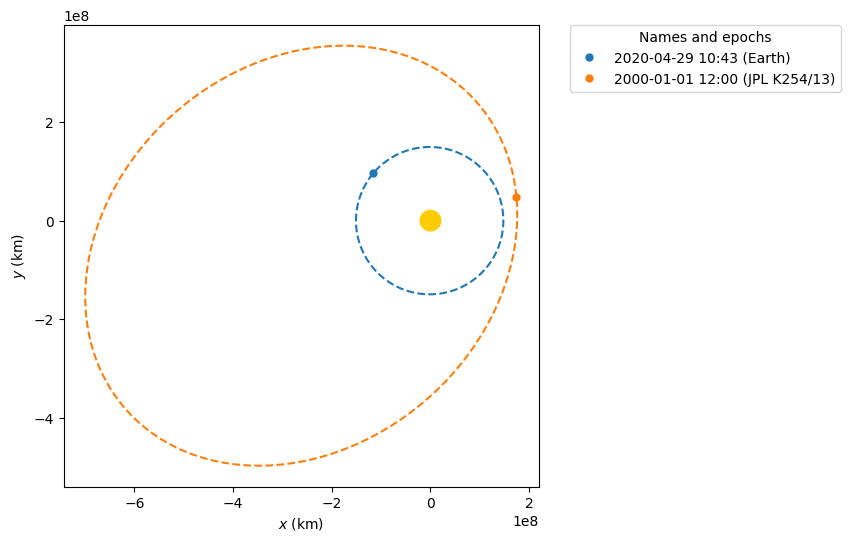

In [100]:
token = "7192458162:AAHZJFNvnep2P1dA2HEsEPSOLOehbCSTHvM"
global choice
choice = ""
updater = updater = Updater(token)
dispatcher = updater.dispatcher

dispatcher.add_handler(CommandHandler("start", start))
dispatcher.add_handler(CommandHandler('search', search))
dispatcher.add_handler(CommandHandler('searchcb', search_by_cb))
dispatcher.add_handler(CommandHandler('menu', menu))
dispatcher.add_handler(CommandHandler('year', year))
dispatcher.add_handler(CommandHandler('tipo', tipo))
dispatcher.add_handler(CommandHandler('orb', orbit_plotter))
dispatcher.add_handler(CommandHandler('classe', classe))
dispatcher.add_handler(CommandHandler('orbid', orbid))
dispatcher.add_handler(MessageHandler(Filters.text, msgHandler))
dispatcher.add_handler(CallbackQueryHandler(buttons_handler))

updater.start_polling()
updater.idle()